In [1]:
from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [2]:
import cmdstanpy
cmdstanpy.install_cmdstan()
a=cmdstan_path()

Installing CmdStan version: 2.31.0
Install directory: /root/.cmdstan
Download successful, file: /tmp/tmp3ymlumk6
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.31.0
Building version cmdstan-2.31.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Test model compilation
Installed cmdstan-2.31.0


In [3]:
# Importing 2017-18 season results
#X = pd.read_excel("/Users/alessandropreti/jupyter/progetto bayesian /data/SerieA_basket.xlsx", sheet_name = "Stagione 2018-19")
X = pd.read_excel("SerieA_basket.xlsx", sheet_name = "Stagione 2017-18")
cols = X.columns
X.head()

,Date,Team,PTS,Opp,PTS2
0,"Sat, Sep 30, 2017",Virtus Segafredo Bologna,74,Dolomiti Energia Trentino,78
1,"Sun, Oct 1, 2017",FIAT Torino,72,Happy Casa Brindisi,67
2,"Sun, Oct 1, 2017",EA7 Emporio Armani Milano,76,Vanoli Cremona,60
3,"Sun, Oct 1, 2017",Germani Basket Brescia,73,VL Pesaro,70
4,"Sun, Oct 1, 2017",Red October Cantù,80,Banco di Sardegna Sassari,94


In [4]:
# Importing 2016-17 season results (used for skill parameters initialization)
#X_old = pd.read_excel("/Users/alessandropreti/jupyter/progetto bayesian /data/SerieA_basket.xlsx", sheet_name = "Stagione 2017-18")
X_old = pd.read_excel("SerieA_basket.xlsx", sheet_name = "Stagione 2016-17")
cols_old = X.columns
X_old.head()

,Date,Team,PTS,Opp,PTS2,Unnamed: 5
0,2016-10-02,Happy Casa Brindisi,69,Dolomiti Energia Trentino,61,2023-10-02
1,2016-10-02,Sidigas Avellino,86,FIAT Torino,83,2023-10-02
2,2016-10-02,Red October Cantù,92,Umana Reyer Venezia,99,2023-10-02
3,2016-10-02,VL Pesaro,76,Germani Basket Brescia,63,2023-10-02
4,2016-10-02,Virtus Segafredo Bologna,78,Grissin Bon Reggio Emilia,75,2023-10-02


In [5]:
# Importing 2018-19 season results (used for test)
#X_old = pd.read_excel("/Users/alessandropreti/jupyter/progetto bayesian /data/SerieA_basket.xlsx", sheet_name = "Stagione 2017-18")
X_test = pd.read_excel("SerieA_basket.xlsx", sheet_name = "Stagione 2018-19")
cols_test = X.columns
X_test.head()

,Date,Team,PTS,Opp,PTS2
0,"Sat, Oct 6, 2018",Red October Cantù,81,Sidigas Avellino,98
1,"Sat, Oct 6, 2018",Vanoli Cremona,104,Dolomiti Energia Trentino,99
2,"Sun, Oct 7, 2018",Happy Casa Brindisi,92,AX Armani Exchange Milano,103
3,"Sun, Oct 7, 2018",OriOra Pistoia,77,VL Pesaro,83
4,"Sun, Oct 7, 2018",Banco di Sardegna Sassari,77,Grissin Bon Reggio Emilia,85


Creiamo vettore Y con risultati

In [6]:
Y = np.array([1 if(X.iloc[i,2]-X.iloc[i,4]>0) else(0) for i in range(X.shape[0])])
X['Y']=Y.tolist()
X.head()

,Date,Team,PTS,Opp,PTS2,Y
0,"Sat, Sep 30, 2017",Virtus Segafredo Bologna,74,Dolomiti Energia Trentino,78,0
1,"Sun, Oct 1, 2017",FIAT Torino,72,Happy Casa Brindisi,67,1
2,"Sun, Oct 1, 2017",EA7 Emporio Armani Milano,76,Vanoli Cremona,60,1
3,"Sun, Oct 1, 2017",Germani Basket Brescia,73,VL Pesaro,70,1
4,"Sun, Oct 1, 2017",Red October Cantù,80,Banco di Sardegna Sassari,94,0


In [7]:
Y_old = np.array([1 if(X_old.iloc[i,2]-X_old.iloc[i,4]>0) else(0) for i in range(X_old.shape[0])])
X_old['Y']=Y_old.tolist()
X_old.head()

,Date,Team,PTS,Opp,PTS2,Unnamed: 5,Y
0,2016-10-02,Happy Casa Brindisi,69,Dolomiti Energia Trentino,61,2023-10-02,1
1,2016-10-02,Sidigas Avellino,86,FIAT Torino,83,2023-10-02,1
2,2016-10-02,Red October Cantù,92,Umana Reyer Venezia,99,2023-10-02,0
3,2016-10-02,VL Pesaro,76,Germani Basket Brescia,63,2023-10-02,1
4,2016-10-02,Virtus Segafredo Bologna,78,Grissin Bon Reggio Emilia,75,2023-10-02,1


In [8]:
Y_test = np.array([1 if(X_test.iloc[i,2]-X_test.iloc[i,4]>0) else(0) for i in range(X_test.shape[0])])
X_test['Y']=Y_test.tolist()
X_test.head()

,Date,Team,PTS,Opp,PTS2,Y
0,"Sat, Oct 6, 2018",Red October Cantù,81,Sidigas Avellino,98,0
1,"Sat, Oct 6, 2018",Vanoli Cremona,104,Dolomiti Energia Trentino,99,1
2,"Sun, Oct 7, 2018",Happy Casa Brindisi,92,AX Armani Exchange Milano,103,0
3,"Sun, Oct 7, 2018",OriOra Pistoia,77,VL Pesaro,83,0
4,"Sun, Oct 7, 2018",Banco di Sardegna Sassari,77,Grissin Bon Reggio Emilia,85,0


Text(0.5, 1.0, 'Histogram of results')

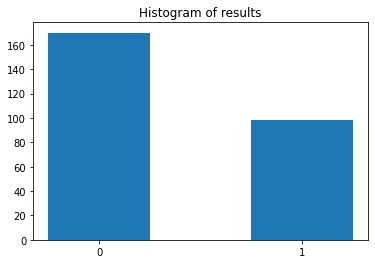

In [9]:
plt.hist(Y, bins=[-0.5, 0.5, 1.5], align='mid', rwidth=0.5)
plt.xticks([0, 1])
plt.title('Histogram of results')
#plt.savefig('histbasket')

Text(0.5, 1.0, 'Histogram of results (old)')

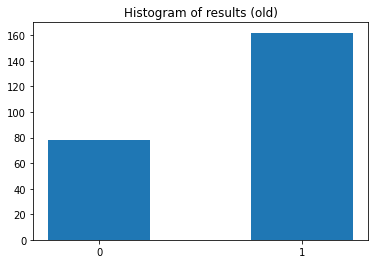

In [10]:
plt.hist(Y_old, bins=[-0.5, 0.5, 1.5], align='mid', rwidth=0.5)
plt.xticks([0, 1])
plt.title('Histogram of results (old)')
#plt.savefig('histbasket')

Text(0.5, 1.0, 'Histogram of results (test)')

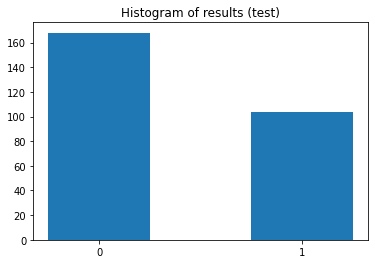

In [11]:
plt.hist(Y_test, bins=[-0.5, 0.5, 1.5], align='mid', rwidth=0.5)
plt.xticks([0, 1])
plt.title('Histogram of results (test)')

In [12]:
Teams_old=list(X_old.iloc[:,1].unique())
Teams_old=sorted(Teams_old)

In [13]:
Teams=list(X.iloc[:,1].unique())
Teams=sorted(Teams)
#len(Teams)

In [14]:
Teams_test=list(X_test.iloc[:,1].unique())
Teams_test=sorted(Teams_test)
#len(Teams)

In [15]:
Teams_old

['AX Armani Exchange Milano',
 'Banco di Sardegna Sassari',
 "Betaland Capo d'Orlando",
 'Dolomiti Energia Trentino',
 'FIAT Torino',
 'Germani Basket Brescia',
 'Grissin Bon Reggio Emilia',
 'Happy Casa Brindisi',
 'Openjobmetis Varese',
 'OriOra Pistoia',
 'Red October Cantù',
 'Sidigas Avellino',
 'Umana Reyer Venezia',
 'VL Pesaro',
 'Vanoli Cremona',
 'Virtus Segafredo Bologna']

In [16]:
Teams

['Banco di Sardegna Sassari',
 "Betaland Capo d'Orlando",
 'Dolomiti Energia Trentino',
 'EA7 Emporio Armani Milano',
 'FIAT Torino',
 'Germani Basket Brescia',
 'Grissin Bon Reggio Emilia',
 'Happy Casa Brindisi',
 'Openjobmetis Varese',
 'Red October Cantù',
 'Sidigas Avellino',
 'The Flexx Pistoia',
 'Umana Reyer Venezia',
 'VL Pesaro',
 'Vanoli Cremona',
 'Virtus Segafredo Bologna']

In [17]:
Teams_test

['AX Armani Exchange Milano',
 'Alma Pallacanestro Trieste',
 'Banco di Sardegna Sassari',
 'Dolomiti Energia Trentino',
 'FIAT Torino',
 'Germani Basket Brescia',
 'Grissin Bon Reggio Emilia',
 'Happy Casa Brindisi',
 'Openjobmetis Varese',
 'OriOra Pistoia',
 'Red October Cantù',
 'Sidigas Avellino',
 'Umana Reyer Venezia',
 'VL Pesaro',
 'Vanoli Cremona',
 'Virtus Segafredo Bologna']

#### Note on teams:

All Milano names should be 'AX Armani Exchange Milano'

All Pistoia names should be 'OriOra Pistoia'

Sobstituting Capo d'Orlando with Trieste





In [18]:
# Fixing Milano
X.loc[X.Team == 'EA7 Emporio Armani Milano', 'Team'] = 'AX Armani Exchange Milano'
X.loc[X.Opp == 'EA7 Emporio Armani Milano', 'Opp'] = 'AX Armani Exchange Milano'

# Fixing Pistoia
X.loc[X.Team == 'The Flexx Pistoia', 'Team'] = 'OriOra Pistoia'
X.loc[X.Opp == 'The Flexx Pistoia', 'Opp'] = 'OriOra Pistoia'

# Fixing Trieste
X_old.loc[X_old.Team == "Betaland Capo d'Orlando", 'Team'] = 'Alma Pallacanestro Trieste'
X_old.loc[X_old.Opp == "Betaland Capo d'Orlando", 'Opp'] = 'Alma Pallacanestro Trieste'

X.loc[X.Team == "Betaland Capo d'Orlando", 'Team'] = 'Alma Pallacanestro Trieste'
X.loc[X.Opp == "Betaland Capo d'Orlando", 'Opp'] = 'Alma Pallacanestro Trieste'

# Recomputing Teams lists to check
Teams_old=list(X_old.iloc[:,1].unique())
Teams_old=sorted(Teams_old)

Teams=list(X.iloc[:,1].unique())
Teams=sorted(Teams)

In [40]:
Teams == Teams_old

True

In [20]:
Teams == Teams_test

True

In [21]:
X['Team'].value_counts()

Dolomiti Energia Trentino     22
AX Armani Exchange Milano     21
Germani Basket Brescia        18
Umana Reyer Venezia           18
Red October Cantù             17
Vanoli Cremona                17
Sidigas Avellino              17
Openjobmetis Varese           17
FIAT Torino                   16
Virtus Segafredo Bologna      15
Grissin Bon Reggio Emilia     15
OriOra Pistoia                15
Banco di Sardegna Sassari     15
VL Pesaro                     15
Alma Pallacanestro Trieste    15
Happy Casa Brindisi           15
Name: Team, dtype: int64

In [22]:
X['Opp'].value_counts()

Dolomiti Energia Trentino     23
AX Armani Exchange Milano     22
Germani Basket Brescia        19
Umana Reyer Venezia           19
Sidigas Avellino              17
Vanoli Cremona                16
Openjobmetis Varese           16
Red October Cantù             16
Happy Casa Brindisi           15
VL Pesaro                     15
Banco di Sardegna Sassari     15
Alma Pallacanestro Trieste    15
FIAT Torino                   15
Grissin Bon Reggio Emilia     15
Virtus Segafredo Bologna      15
OriOra Pistoia                15
Name: Opp, dtype: int64

In [23]:
max(X['Opp'].value_counts())

23

In [24]:
len(Teams)

16

In [25]:
def names_to_index(Teams):

    """
    Creates a dictionary that associates teams to number
    """
    # dictionary comprehension
    d = {index: value for value, index in enumerate(Teams)}

    return d

In [26]:
def crea_matrici(X):
    """
    Takes as input a matrix X and their result to create two additional matrices that can be used for our model
    """
    #matrice casa trasferta risultato in numeri (N_match, 3)
    Y = np.array([1 if(X.iloc[i,2]-X.iloc[i,4]>0) else(0) for i in range(X.shape[0])])
    
    Teams=list(X.iloc[:,1].unique())
    Teams=sorted(Teams)
    d = names_to_index(Teams)
    
    T_1 = np.array([d[X.iloc[i,1]] for i in range(X.shape[0])])
    T_2 = np.array([d[X.iloc[i,3]] for i in range(X.shape[0])])
    R = pd.DataFrame({"Home":T_1,"Away":T_2,"Result":Y})
    
    #matrice di storie delle squadre, casa-trasferta (N_Teams, 2)
    dim_vec_home = R['Home'].value_counts()
    dim_vec_away = R['Away'].value_counts()
    
    R2 = pd.DataFrame(index = sorted(np.unique(T_1)), columns = ["Home", "Away"])
    
    for i in range(len(np.unique(T_1))):
        R2["Home"][i] = np.empty(0,dtype = np.int8)
        R2["Away"][i] = np.empty(0,dtype = np.int8)
        
    for i in range(len(T_1)):
        h = R["Home"][i]
        a = R["Away"][i]
        R2["Home"][h] = np.append(R2["Home"][h],R["Result"][i])
        R2["Away"][a] = np.append(R2["Away"][a], 1 - R["Result"][i])
    m=max(max(X['Opp'].value_counts()),max(X['Team'].value_counts()))
    print('The length of the array is: ',m)
    for i in range(R2.shape[0]):
      while(len(R2["Home"][i])<m):
        R2["Home"][i]=np.append(R2["Home"][i],0)
      while(len(R2["Away"][i])<m):
        R2["Away"][i]=np.append(R2["Away"][i],0)
    
    
    return R,R2


In [27]:
def compute_skills(R,R2,init_home,init_away,l1=0.5, l2=0.5):
    """
    Takes as inputs a matrix X with teams and their result
    init is the inizialization of the skills, must be an array or list with the skill for each team.

    Returns two matrices with home and away skills parameters by team 
    and one matrix with skills parameters oredered cronologically
    """
    import numpy as np
    import pandas as pd

    N=R.shape[0] # number of matches
    

    #Creating matrices to store the skill parameters and their stories
        
    HS = pd.DataFrame(index = R2.index, columns = ["Home", "Away"])
    
    for i in range(R2.shape[0]):
        HS["Home"][i] = np.empty(0)
        HS["Away"][i] = np.empty(0)
        
    data = pd.DataFrame(index = R.index, columns=['Home','Away'])
    C = pd.DataFrame({"Home": np.zeros(len(R2.index), dtype = np.int8), "Away": np.zeros(len(R2.index), dtype = np.int8)})
    
    for i in range(R.shape[0]):
        h = R["Home"][i]
        a = R["Away"][i]

    # HOME SKILL
        if(C["Home"][h]==0):
          xh = init_home[h]
        else:
          #calcolo somma per xh
          sh = 0
          for j in range(C["Home"][h]):
              sh = sh + R2["Home"][h][j]*(1-l1)**j
        
          xh = l1*sh + init_home[h]*(1-l1)**C["Home"][h]

     # AWAY SKILL       
        if(C["Away"][a]==0):
          xv = init_away[a]
        else:
          #calcolo somma per xv
          sa = 0
          for j in range(C["Away"][a]):
             sa = sa + R2["Away"][a][j]*(1-l2)**j
        
          xv = l2*sa + init_away[a]*(1-l2)**C["Away"][a]
        
        #append nostra matrice storico e dati per stan
        HS["Home"][h] = np.append(HS["Home"][h],round(xh,3))
        HS["Away"][a] = np.append(HS["Away"][a],round(xv,3))
        data["Home"][i] = round(xh,3)
        data["Away"][i] = round(xv,3)
        
        #incremento counts
        C["Home"][h] += 1
        C["Away"][a] += 1

    
    return HS,data

The length of the array is:  16


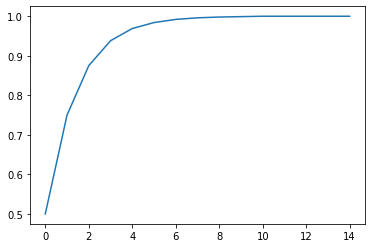

In [28]:
R_old, R2_old = crea_matrici(X_old)
HS_old, data_old = compute_skills(R_old, R2_old, 0.5*np.ones(len(Teams)), 0.5*np.ones(len(Teams)))

plt.plot(HS_old["Home"][0])

In [29]:
init_home = np.empty(0)
init_away = np.empty(0)

for i in range(HS_old.shape[0]):
  init_home = np.append(init_home,HS_old["Home"][i][-1])
  init_away = np.append(init_away,HS_old["Away"][i][-1])

R,R2 = crea_matrici(X)

The length of the array is:  23


In [30]:
logit_reg='''

data{    
    int<lower=0> N; // Matches
    array[N] int y;
    int<lower=0> T; // Teams
    array[N,3] int R;  // Game+Result matrix
    array[T,2,23] int R2; // Teams' history
    vector[T] IH;    // init_home
    vector[T] IA;    // init_away
}


parameters{
    real mu0;
    real sigma0;
    vector[2] beta;
    real int_raw;
    real<lower=0,upper=1> l1;
    real<lower=0,upper=1> l2;
}

transformed parameters{
  matrix[N,2] X;     // Skills
  real sh;
  real sa;
  vector[N] mu;
  real intercept;
  {
  array[T,2] int C=rep_array(0,T,2);

  for(i in 1:N){
    int h = R[i,1]+1; // Home team index
    int a = R[i,2]+1; // Away team index
    int ch = C[h,1]; // Home count
    int ca = C[a,2]; //Away count

    // Home team skill update
    if(ch==0){
      X[i,1] = IH[h];
    }
    else{
      sh=0;
      for(j in 1:ch){   
        sh=sh+R2[h,1,j]*pow((1-l1),j);
        }
      X[i,1]=l1*sh+IH[h]*pow((1-l1),ch);
    }

    // Away team skill update
    if(ca==0){
      X[i,2] = IA[a];
    }
    else{
      sa=0;
      for(j in 1:ca){   
        sa=sa+R2[a,2,j]*pow((1-l2),j);
      }
      X[i,2]=l2*sa+IA[a]*pow((1-l2),ca);
    }

    // Count update
    C[h,1]=C[h,1]+1;
    C[a,2]=C[a,2]+1;

    mu[i] = row(X, i) * beta;
  }
  intercept = mu0 + int_raw * sigma0;
  }
}

model{
    mu0 ~ normal(0, 1./10);
    sigma0 ~ inv_gamma(0.1, 1/0.01);

    int_raw ~ normal(0,1);
    
    beta[1] ~ normal(0,3);
    beta[2] ~ normal(0,3);
    

    l1 ~ beta(2,2);
    l2 ~ beta(2,2);

    for (i in 1:N){
        y[i] ~ bernoulli_logit(intercept + mu[i]);
   }
}

generated quantities{
  vector[N] y_pred; 
  for(i in 1:N){
    y_pred[i] = bernoulli_logit_rng(intercept + mu[i]);
  }
}
'''

stan_file = "./logit.stan"

with open(stan_file, "w") as f:
    print(logit_reg, file=f)

logit_reg = CmdStanModel(stan_file=stan_file)

06:51:19 - cmdstanpy - INFO - compiling stan file /content/logit.stan to exe file /content/logit
INFO:cmdstanpy:compiling stan file /content/logit.stan to exe file /content/logit
DEBUG:cmdstanpy:cmd: make /content/logit
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/content/logit.hpp /content/logit.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/logit.o /content/logit.hpp
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-

In [31]:
model_data = {'N': len(Y), 'y': Y, 'T': len(Teams), 'R': R, 'R2': R2.values.tolist(), 'IH': init_home, 'IA': init_away}

model_fit=logit_reg.sample(data=model_data, chains=4,
                           parallel_chains=4, iter_warmup=1000,
                           iter_sampling=5000, adapt_delta=0.999,
                           step_size = 0.5, max_treedepth = 15)
#model_fit=logit_reg.sample(data=model_data, chains=4, parallel_chains=4, iter_warmup=1000,iter_sampling=2000)
model_data=az.from_cmdstanpy(model_fit)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpomocu_6p/ta6t3w99.json
DEBUG:cmdstanpy:cmd: /content/logit info
cwd: None
06:51:38 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/logit', 'id=1', 'random', 'seed=44778', 'data', 'file=/tmp/tmpomocu_6p/ta6t3w99.json', 'output', 'file=/tmp/tmpomocu_6p/logit881ptkgq/logit-20230213065138_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'stepsize=0.5', 'adapt', 'engaged=1', 'delta=0.999']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/logit', 'id=2', 'random', 'seed=44778', 'data', 'file=/tmp/tmpomocu_6p/ta6t3w99.json', 'output', 'file=/tmp/tmpomocu_6p/logit881ptkgq/logit-20230213065138_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'stepsize=0.5', 'adapt', 'engaged=1', 'delta=0.999']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/logit', 'id=3', 'random', '

08:24:47 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/logit', 'id=1', 'random', 'seed=44778', 'data', 'file=/tmp/tmpomocu_6p/ta6t3w99.json', 'output', 'file=/tmp/tmpomocu_6p/logit881ptkgq/logit-20230213065138_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'stepsize=0.5', 'adapt', 'engaged=1', 'delta=0.999']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpomocu_6p/logit881ptkgq/logit-20230213065138_1.csv
 console_msgs (if any):
	/tmp/tmpomocu_6p/logit881ptkgq/logit-20230213065138_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000

08:24:48 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.1%)
	Chain 3 had 7 divergent transitions (0.1%)
	Chain 4 had 5 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
	Chain 1 had 3 divergent transitions (0.1%)
	Chain 3 had 7 divergent transitions (0.1%)
	Chain 4 had 5 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


In [32]:
cmdstanpy_data = az.from_cmdstanpy(model_fit)
np.sum(cmdstanpy_data.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(15)

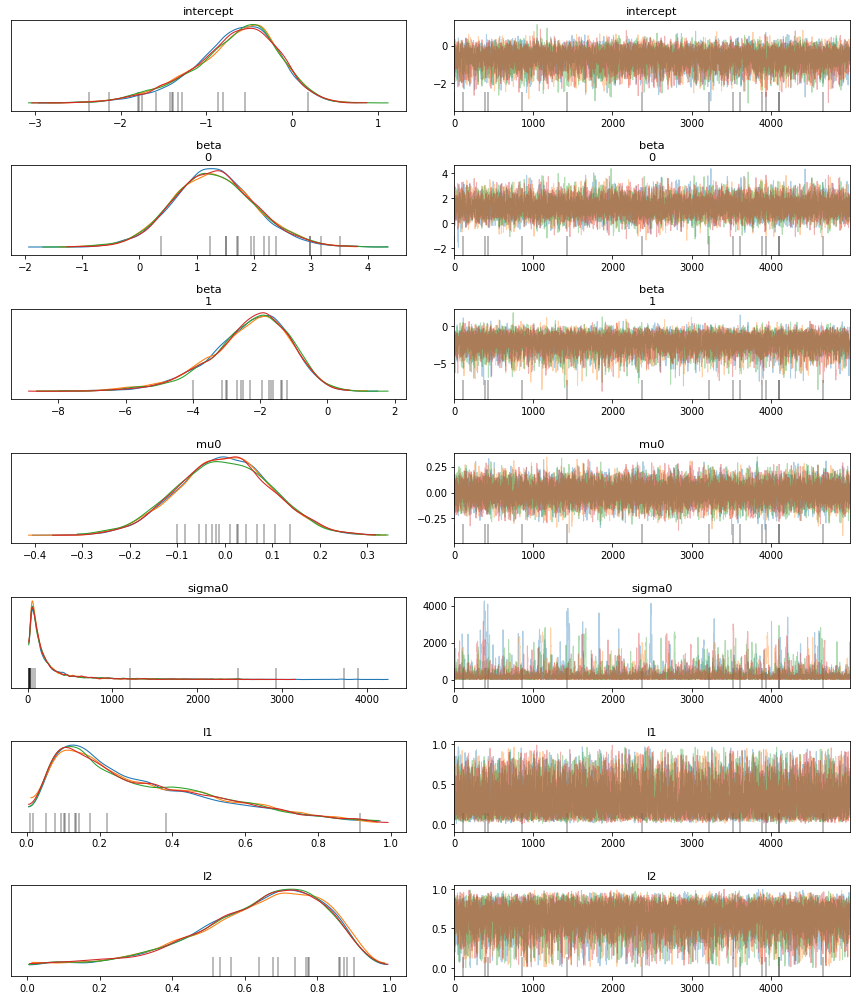

In [33]:
az.plot_trace(model_data, var_names=["intercept","beta","mu0" ,"sigma0","l1","l2"], compact=False)
plt.tight_layout()
plt.show()

Test Prediction 

In [34]:
SR = model_fit.summary()["Mean"]

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.31.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpomocu_6p/stansummary-logit-uunjhv7d.csv /tmp/tmpomocu_6p/logit881ptkgq/logit-20230213065138_1.csv /tmp/tmpomocu_6p/logit881ptkgq/logit-20230213065138_2.csv /tmp/tmpomocu_6p/logit881ptkgq/logit-20230213065138_3.csv /tmp/tmpomocu_6p/logit881ptkgq/logit-20230213065138_4.csv
cwd: None


In [ ]:
# Retrieve last match played by each team to retrieve last skill
def last_skill(SR):
  last_match_home = {}
  for team in Teams:
      team_matches = X[(X['Team'] == team)].sort_index(ascending=False)
      last_match_home[team] = team_matches.index[0]

  last_match_away = {}
  for team in Teams:
      team_matches = X[(X['Opp'] == team)].sort_index(ascending=False)
      last_match_away[team] = team_matches.index[0]

  init_home = np.empty(0)
  init_away = np.empty(0)
  for team in Teams:
    sh = "X["+str(last_match_home[team])+",1]"
    init_home = np.append(init_home,SR[sh])
    sa = "X["+str(last_match_home[team])+",2]"
    init_away = np.append(init_away,SR[sa])
  
  return init_home,init_away

In [ ]:
def prediction(model, new_data, SR):
  
  R, R2 = crea_matrici(new_data)

  init_home,init_away = last_skill(SR)

  HS, data = compute_skills(R, R2, init_home, init_away, l1 = SR["l1"], l2 = SR["l2"])

  prob = []

  for i in range(new_data.shape[0]):
    odds = np.exp((SR["intercept"]) + SR["beta[1]"]*data["Home"][i] + SR["beta[2]"]*data["Away"][i])
    prob = np.append(prob, odds/(odds + 1))
  
  return prob


Prediction on new season

In [ ]:
prob = prediction(model_fit, X_test, SR)

print("Ne azzecchiamo il ",sum(X_test["Y"]==np.round(prob,0))/X_test.shape[0]*100,"%")

In [38]:
y_pred = np.round(prob,0)

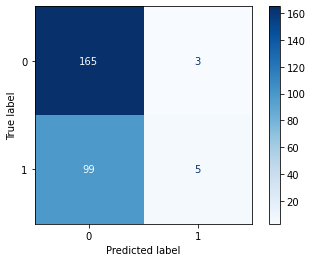

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.98      0.76       168
           1       0.62      0.05      0.09       104

    accuracy                           0.62       272
   macro avg       0.62      0.52      0.43       272
weighted avg       0.62      0.62      0.51       272



In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm= confusion_matrix(X_test["Y"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')
target_names = ["0","1"]
print(classification_report(X_test["Y"], y_pred, target_names=target_names))